<a href="https://colab.research.google.com/github/Ngolobe/Forecasting-The-Stock-Market-with-Machine-Learning/blob/master/deepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Downloading the Data


In [36]:
# Define the instruments to download. We would like to see the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/1971 until 12/31/2019.
start_date = '1971-01-01'
end_date = '2019-12-31'

# Use pandas_reader.data.DataReader to load the desired data. 
df = data.DataReader('^GSPC', 'yahoo', start_date, end_date)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1971-01-04,92.190002,90.639999,92.150002,91.150002,10010000,91.150002
1971-01-05,92.279999,90.690002,91.150002,91.800003,12600000,91.800003
1971-01-06,93.000000,91.500000,91.800003,92.349998,16960000,92.349998
1971-01-07,93.260002,91.750000,92.349998,92.379997,16460000,92.379997
1971-01-08,93.019997,91.599998,92.379997,92.190002,14100000,92.190002


In [41]:
df = df.reset_index()

In [43]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

##Data Exploration and Visualization

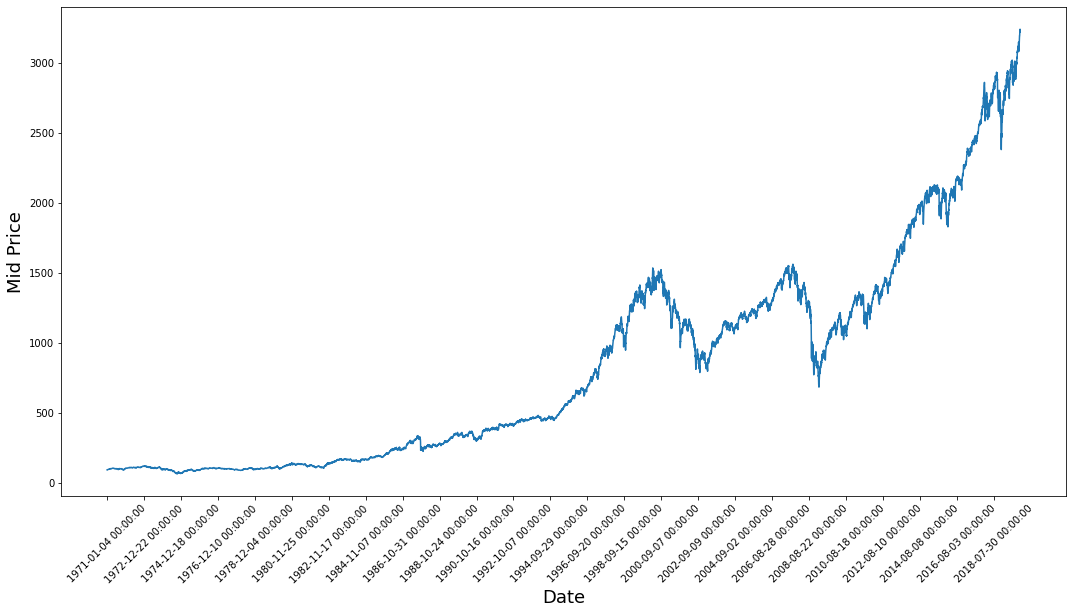

In [44]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

##Splitting Data into a Training set and a Test set

In [7]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [45]:
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

##Normalizing the Data

Now you need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features].

In [46]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

Due to the observation you made earlier, that is, different time periods of data have different value ranges, you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here you choose a window size of 2500.

Tip: when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 4 data points will be affected by this. But given you have 11,000 data points, 4 points will not cause any issue

In [47]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

Reshape the data back to the shape of [data_size]

In [48]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.

In [49]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

##One-Step Ahead Prediction via Averaging

Averaging mechanisms allow you to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. You will look at two averaging techniques below; standard averaging and exponential moving average. You will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

###Standard Average

You can understand the difficulty of this problem by first trying to model this as an average calculation problem. First you will try to predict the future stock market prices (for example, xt+1 ) as an average of the previously observed stock market prices within a fixed size window (for example, xt-N, ..., xt) (say previous 100 days). Thereafter you will try a bit more fancier "exponential moving average" method and see how well that does. Then you will move on to the "holy-grail" of time-series prediction; Long Short-Term Memory models.

First you will see how normal averaging works. That is you say,
 $$ x_{t+1}=\frac{1}{N}\sum_{i=t-N}^{t} x_{i}$$
In other words, you say the prediction at t+1
is the average value of all the stock prices you observed within a window of t to t−N.

In [51]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00372


Take a look at the averaged results below. It follows the actual behavior of stock quite closely. Next, you will look at a more accurate one-step prediction method.